In [1]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2

In [6]:
EPOCHS = 200
BS = 8
default_image_size = tuple((300, 300))
directory_root = 'C:/Users/emada/OneDrive/Desktop/FAST TRACK FALL SEM(2023-2024)/DL Project/thermal images UL'

In [7]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir:
        if directory == ".DS_Store":
            root_dir.remove(directory)

    for plant_folder in root_dir:
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        for disease_folder in plant_disease_folder_list:
            if disease_folder == ".DS_Store":
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list:
                if single_plant_disease_image == ".DS_Store":
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:  # Limiting to a smaller number for demonstration purposes
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") or image_directory.endswith(".JPG"):
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error: {e}")

[INFO] Loading images ...
Error: [WinError 3] The system cannot find the path specified: '/thermal images UL'


In [11]:
image_size = len(image_list)

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)

np_image_list = np.array(image_list, dtype=np.float16) / 255.0  # Normalize the pixel values

print("[INFO] Splitting data into train and test sets")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=42)


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

base_model.trainable = True
for layer in base_model.layers[:-25]:  # Unfreeze the last 20 layers
    layer.trainable = False
    
# Create the model by adding custom Dense layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # Global Average Pooling to reduce the spatial dimensions
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization
model.add(Dropout(0.5))  # Adding Dropout layer with 50% dropout rate
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

['BLB' 'Blast' 'healthy' 'hispa' 'leaf folder' 'leaf spot']
[INFO] Splitting data into train and test sets
9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)  

In [12]:
# Define the learning rate schedule function

def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 15:
        return initial_lr
    else:
        return initial_lr / 100

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Fit the model
history = model.fit(x_train, y_train,
                    batch_size=BS,
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler])

Epoch 1/200
62/62 [==============================] - 18s 59ms/step - loss: 2.4576 - accuracy: 0.4451 - val_loss: 9.7073 - val_accuracy: 0.3871 - lr: 0.0010
Epoch 2/200
62/62 [==============================] - 2s 26ms/step - loss: 1.6510 - accuracy: 0.6484 - val_loss: 11.6810 - val_accuracy: 0.4032 - lr: 0.0010
Epoch 3/200
62/62 [==============================] - 2s 27ms/step - loss: 1.3741 - accuracy: 0.6748 - val_loss: 11.7381 - val_accuracy: 0.4113 - lr: 0.0010
Epoch 4/200
62/62 [==============================] - 2s 28ms/step - loss: 1.0233 - accuracy: 0.7602 - val_loss: 24.9780 - val_accuracy: 0.3790 - lr: 0.0010
Epoch 5/200
62/62 [==============================] - 2s 27ms/step - loss: 0.8397 - accuracy: 0.8049 - val_loss: 25.6716 - val_accuracy: 0.3790 - lr: 0.0010
Epoch 6/200
62/62 [==============================] - 2s 26ms/step - loss: 0.7238 - accuracy: 0.8577 - val_loss: 30.5105 - val_accuracy: 0.3790 - lr: 0.0010
Epoch 7/200
62/62 [==============================] - 2s 29ms/ste

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")

4/4 [==============================] - 1s 199ms/step - loss: 0.1157 - accuracy: 0.9677
Test accuracy: 0.9677419066429138


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


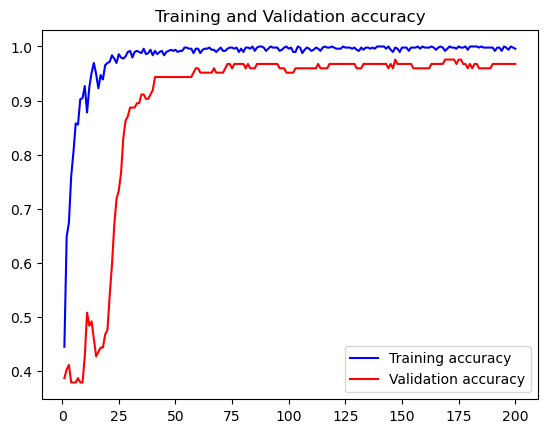

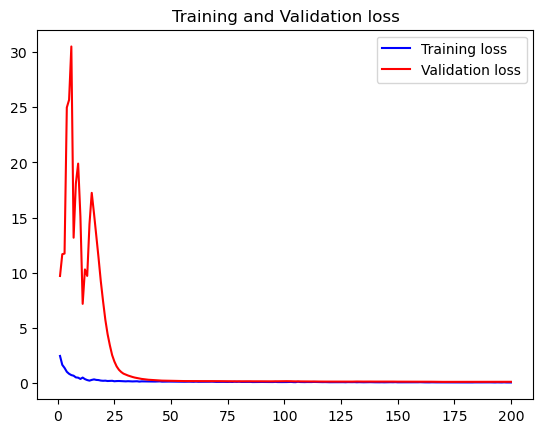

In [14]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [15]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
4/4 [==============================] - 0s 50ms/step - loss: 0.1157 - accuracy: 0.9677
Test Accuracy: 96.77419066429138


(1, 300, 300, 3)
1/1 [==============================] - 1s 1s/step
[[2.8808623e-07 4.0636124e-07 9.9999917e-01 1.5200460e-07 1.5446570e-08
  2.1477900e-08]]
Predicted Class: healthy
Probability: 1.0000


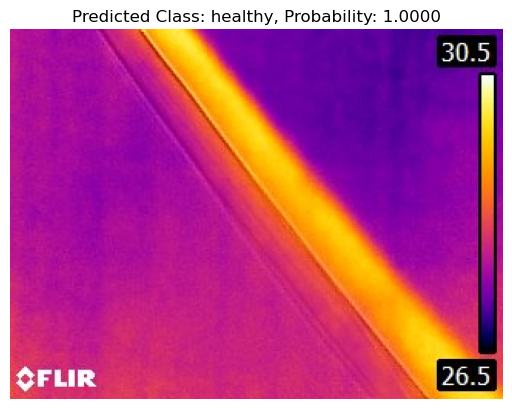

In [16]:
#1st output

default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/healthy/thermalimage.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 [==============================] - 0s 24ms/step
[[3.4631090e-04 5.1937700e-06 2.0136335e-07 1.1382353e-06 1.4812280e-08
  9.9964714e-01]]
Predicted Class: leaf spot
Probability: 0.9996


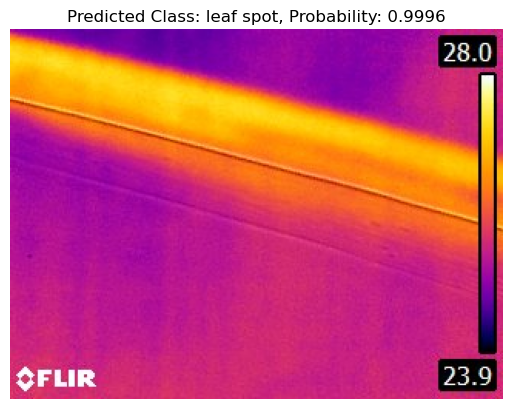

In [17]:
#2nd output

default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/leaf spot/thermalimage10a.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 [==============================] - 0s 25ms/step
[[4.1166400e-06 5.6068579e-06 2.6106857e-06 9.9997735e-01 9.0985031e-06
  1.1675174e-06]]
Predicted Class: hispa
Probability: 1.0000


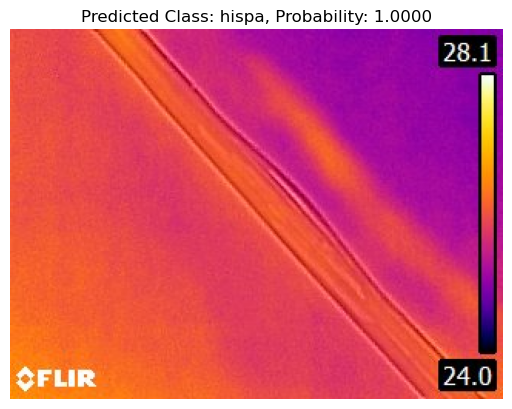

In [18]:
#3rd output

default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/hispa/thermalimage.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 [==============================] - 0s 23ms/step
[[9.9988806e-01 1.5178038e-06 7.0400842e-05 3.1599600e-05 5.5507521e-06
  2.7801032e-06]]
Predicted Class: BLB
Probability: 0.9999


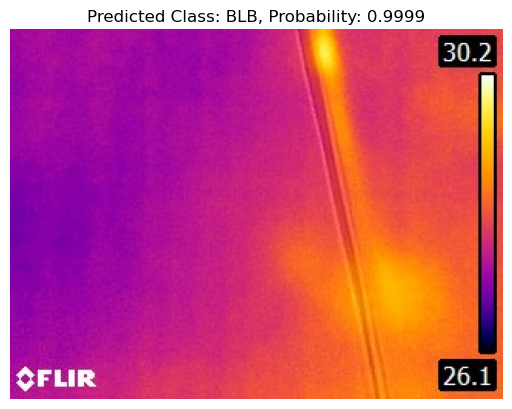

In [19]:
#4th output

default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/BLB/thermalimage100a.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 [==============================] - 0s 23ms/step
[[2.7606642e-05 9.9980503e-01 7.9469872e-05 4.2094220e-05 6.5706231e-06
  3.9193044e-05]]
Predicted Class: Blast
Probability: 0.9998


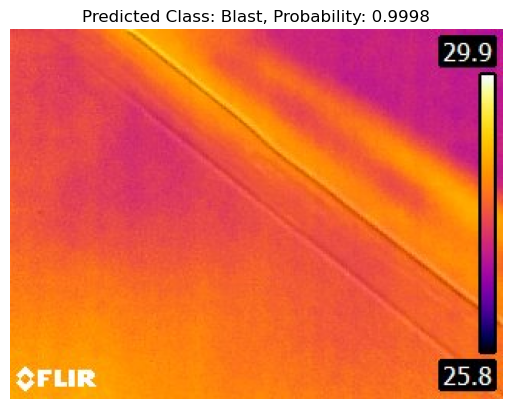

In [20]:
#5th output

default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/Blast/Thermalimage10a.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 [==============================] - 0s 23ms/step
[[2.5545464e-06 8.5241245e-06 8.1409089e-06 5.9164249e-05 9.9992096e-01
  6.1080175e-07]]
Predicted Class: leaf folder
Probability: 0.9999


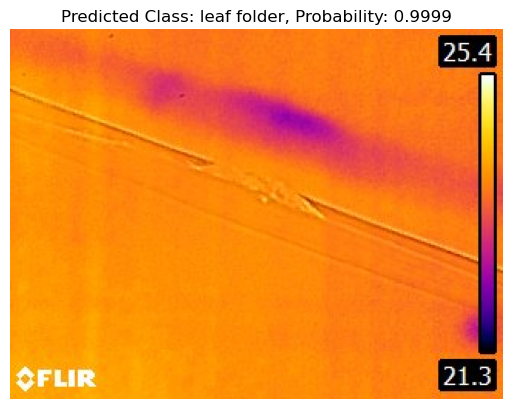

In [22]:
#6th output

default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/leaf folder/thermalimage10a.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()